## Task II

In this task we will aim to classify images from the CIFAR-10 dataset using convolutional neural networks, CNNs. 

In the first code cell, we import all necessary Python libaries and modules for our image classification task.

## Libraries

In [2339]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from PIL import Image
import torchvision
from torchvision.transforms import v2
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import Subset, DataLoader
from torch.utils.data import Dataset
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning import Trainer

- Snakke om hvilke bibliotek vi bruker og hvorfor (pytorch)
- fordeler og ulemper med dem
- Hvilke alternativ vi hadde å velge mellom

### Transforms

First, we begin by defining a transformation pipeline to properly preprocess the data. The goal of an image transform is to augment or prepare the image in a way that makes it more suitable for the model. In our case, we use the Compose class to chain multiple transformations together.

The first transformation we apply is `ToTensor()`, which converts a PIL image or a NumPy ndarray into a `torch.FloatTensor`. This conversion is important because PyTorch models expect tensor inputs. During this step, the shape of the image is changed from the standard PIL format of (Height x Width x Channels) to the PyTorch format of (Channels x Height x Width). Additionally, `ToTensor()` scales the pixel values from the range [0, 255] (common in image data) to a normalized floating-point range of [0.0, 1.0], making the data numerically more manageable and consistent for the model.

Next, we apply the `Normalize()` transformation. This step standardizes the pixel values by subtracting the mean and dividing by the standard deviation for each channel (typically RGB). The Normalize(mean, std) transform is crucial for training deep learning models efficiently, as it centers the data around zero and ensures each channel has a similar scale. In our case, using `Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])` will map the [0.0, 1.0] pixel range to [-1.0, 1.0], which is a common normalization range for neural networks. This helps the model converge faster during training and can lead to better overall performance.

By combining `ToTensor()` and `Normalize()` within a Compose pipeline, we ensure our image data is in the ideal format and scale for input into a PyTorch model.

soruces:
https://pytorch.org/vision/main/transforms.html#:~:text=Transforms%20can%20be%20used%20to,%2C%20segmentation%2C%20video%20classification).
https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html
https://rumn.medium.com/ultimate-guide-to-fine-tuning-in-pytorch-part-3-deep-dive-to-pytorch-data-transforms-53ed29d18dde

In this code cell we prepare the dataset and apply preprocessing steps .

Transformations:  
    
transforms.ToTensor- Converts the PIL images to PyTorch tensors and scales pixel values to [0, 1].    

transforms.Normalize- Normalizes each RGB channel to have a mean of 0 and a standard deviation of 1.This helps stabilize and speed up training.

### Loading the Data

To load the data, we use PyTorch’s built-in `torchvision.datasets.CIFAR10` class, which allows us to download the CIFAR-10 dataset directly into our project directory. This dataset class makes it easy to manage both the training and test sets by simply setting the train parameter to either True or False. When train=True, the class returns the training portion of the dataset; when set to False, it loads the test set instead.

Additionally, we can apply our previously defined transformation pipeline by passing it to the transform parameter of the CIFAR10 class. This ensures that each image is automatically preprocessed (converted to a tensor and normalized) as it's loaded.

Overall, this approach offers a simple, clean, and efficient way to download, organize, and preprocess the dataset using PyTorch’s API.


Sources:
https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html

Classes:    

Defines the 10 class labels in CIFAR-10, which are used for interpretation and visualization later on.

Dataset Loading:        

torchvision.datasets.CIFAR10- oads the CIFAR-10 dataset. We load it twice: once for training and once for testing.

In [2340]:
transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

training_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


- Introdusere normalisering og hvorfor vi bruker denne normaliseringen (Burde vi endre den?) finn formellen for å komme fram til normaliseringen
- Introdusere CIFAR-10 datasettet
- Snakke om treningsdata og testdata til CIFAR-10 datasettet

### About the Data

For training and testing our model, we use the CIFAR-10 dataset—one of the most popular benchmark datasets in computer vision. Created by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton at the Canadian Institute for Advanced Research, CIFAR-10 is a subset of the larger “80 Million Tiny Images” dataset.

CIFAR-10 consists of 60,000 color images, each with a resolution of 32x32 pixels, spanning 10 distinct classes. Each class contains 6,000 images, resulting in 50,000 images allocated for training and 10,000 for testing. The training set is further divided into five batches of 10,000 images each, while the test set comprises one batch of 10,000 images, including exactly 1,000 randomly selected images from each class (cs.toronto.edu).

Due to its manageable size and balanced class distribution, CIFAR-10 is widely used for benchmarking deep learning models, particularly in image classification tasks. It serves as a standard dataset for evaluating Convolutional Neural Networks (CNNs), and other machine learning algorithms. Its simplicity make it an excellent choice for traning of a model such as ours.

sources:
https://docs.ultralytics.com/datasets/classify/cifar10/#dataset-structure
https://www.cs.toronto.edu/~kriz/cifar.html

## Visualisation of the data

Here we inspect the shape of a single image from the training dataset.    

Since we have applied transforms.ToTensor() earlier, the image is now a tensor with shape (3, 32, 32):

    3: RGB channels
    32 x 32: Image height and width 

This confirms that each image in CIFAR-10 is a 32×32 color image.

In [2341]:
# Shape of image
img, label = training_data[0]
img.size()

torch.Size([3, 32, 32])

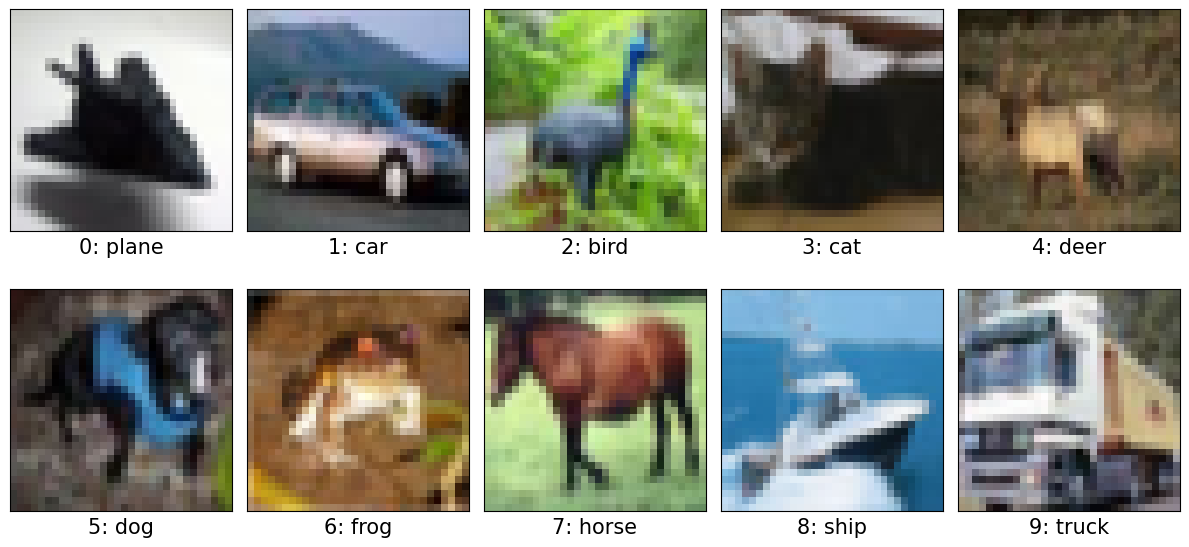

In [2342]:
# Visualize one training image per class
sample_images = [training_data.data[np.asarray(training_data.targets) == label][0] for label in range(10)]

# Create a figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, axis in enumerate(axes.flat):
    axis.set_xlabel(f"{i}: {classes[i]}", fontsize=15)
    axis.imshow(sample_images[i])
    axis.set_xticks([])
    axis.set_yticks([])

plt.tight_layout()
plt.show()


We visualize one sample image for each class.    

sample_images- filter out the images by their class label (using `np.asarray(training_data.targets) == label`) and select the first image for each class.   

plt.subplots(2, 5, figsize=(12, 6))- Creates a grid of 2 rows and 5 columns to display the images. This gives us space to display 10 images, one for each class.    

Loop over axes.flat- For each image:    
    axis.set_xlabel(...)- Adds a label for each image with its corresponding class name.    

    axis.imshow(...)- Displays the image in the current axis.   

    axis.set_xticks([]) and axis.set_yticks([])- Removes the axis ticks for better visualization.   

This gives us a visual overview of what the images in each class look like.

- Vi skal lage en binærklassifiserer for frosker
- Vet ikke helt hva vi kan snakke om her?

In [2343]:
def print_stats(dataset, class_names):
    label_counts = {}

    if isinstance(dataset, Subset):
        targets = dataset.dataset
        indices = dataset.indices
    else:
        targets = dataset
        indices = range(len(dataset))

    for i in indices:
        _, label = targets[i]
        if label not in label_counts:
            label_counts[label] = 0
        label_counts[label] += 1

    print(f"Total images: {len(indices)}")
    for label in sorted(label_counts):
        print(f"Label {label} ({class_names[label]}): {label_counts[label]}")


This code cell defines a helper function called "print_starts()" to explore the distribution of labels in a dataset.    
It calculates and prints the number of images for each class. And it works with both full datasets and subsets.

This is useful for checking if your dataset is balanced, which can affect how well your model performs across different classes.

- Funksjon for å gi infromasjon om et gitt datasett
- Denne blir brukt bare for å få ett overblikk av dataen før og etter vi endrer den
- Denne kan også senere å bli gjort om til å lage grafer til dataen (men vet ikke om det er nødvendig)
- "Bør endre den"

In [2344]:
print("Traning data")
print_stats(training_data, classes)
print("\n")
print("Test data")
print_stats(test_data, classes)

Traning data
Total images: 50000
Label 0 (plane): 5000
Label 1 (car): 5000
Label 2 (bird): 5000
Label 3 (cat): 5000
Label 4 (deer): 5000
Label 5 (dog): 5000
Label 6 (frog): 5000
Label 7 (horse): 5000
Label 8 (ship): 5000
Label 9 (truck): 5000


Test data
Total images: 10000
Label 0 (plane): 1000
Label 1 (car): 1000
Label 2 (bird): 1000
Label 3 (cat): 1000
Label 4 (deer): 1000
Label 5 (dog): 1000
Label 6 (frog): 1000
Label 7 (horse): 1000
Label 8 (ship): 1000
Label 9 (truck): 1000


- Dette blir nok snakket om når vi presenterer dataen
- Men det er sikkert noe å snakke om her 

### Binary dataset class

This code defines a custom dataset class, FrogBinaryDataset, which converts the CIFAR-10 dataset into a binary classification task: identifying whether an image is a frog (label 1) or not (label 0).

We created this class by subclassing PyTorch’s Dataset from torch.utils.data, which provides a standard interface for loading data. By implementing the `__getitem__()` and `__len__()` methods, we can customize how data is accessed and labeled. This approach offers a clean and flexible way to adapt existing datasets for specific tasks like binary classification.

- Dette er en klasse som tar inn ett data sett og gjør "labels" om til binære verdier
- Det er sikkert en bedre måte å gjøre dette på (jeg fant det i dokumentasjon), men det funker :)
- Forklare hvorfor vi gjør dette og hva fordelen med å gjøre dette er

In [2345]:
class FrogBinaryDataset(Dataset):
    def __init__(self, subset):
        self.subset = subset 

    def __getitem__(self, idx):
        data, label = self.subset[idx]
        # Convert to binary: 1 if frog (label 6), else 0
        if label == 6:
            binary_label = 1
        else:
            binary_label = 0
        return data, binary_label
    
    def __len__(self):
        return len(self.subset)

## Building the Trainingdataset

A training dataset is the portion of the data used to teach the model. In the case of a neural network, this is the data the model learns from by adjusting its weights and biases during training. Typically, the training set is the largest portion of the dataset. In our case, it makes up approximately 80% of the total data used.

In our approach, we utilized a combination of the original dataset along with an additional 5,000 augmented frog images. This augmentation strategy significantly enhanced the diversity of our training data, allowing the model to generalize better and improving overall performance. The inclusion of these augmented samples led to noticeable gains in accuracy, particularly in distinguishing subtle variations between frog species.

- Tidligere hadde jeg splittet dataen sånn at det var 50% frosker og 50% en lik fordeling av alle andre klassene, men det gjorde at jeg fikk veldig dårlige resultater under validering så jeg endret det tilbake til dette. Men vi må spørre om det er en annen måte vi kan splitte denne treningsdataen.
- Kan vi endre på forskebildene slik at vi får flere froskebilder å trene på, evt hvordan?

In [2346]:
# Augmented images
augmented_transform = v2.Compose([
    v2.RandomCrop(32, padding=4),
    v2.RandomHorizontalFlip(),
    v2.ColorJitter(brightness=0.2, contrast=0.2),
    v2.ToTensor(),
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [2347]:
# Loading in the dataset to be augmented
augmented_training_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=augmented_transform)

frog_indices = [i for i, (_, label) in enumerate(augmented_training_data) if label == 6]

augmented_frog_iamges = Subset(augmented_training_data, frog_indices)

In [2348]:
# Function to unnormalize the image
def unnormalize(img_tensor):
    return img_tensor * 0.5 + 0.5  # inverse of normalization: (img * std) + mean

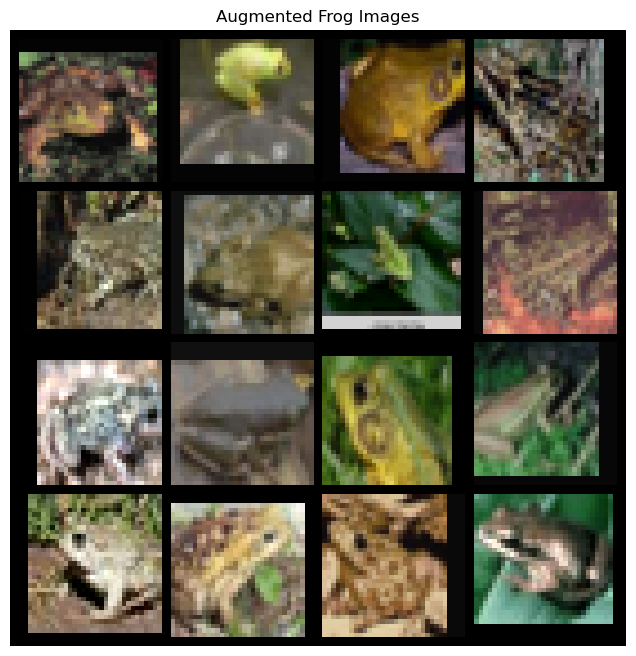

In [2349]:
# Visulize the augmented dataset

# Function to visualize a batch of images

loader = DataLoader(augmented_frog_iamges, batch_size=16, shuffle=True)
data_iter = iter(loader)
images, _ = next(data_iter)

# Unnormalize
images = unnormalize(images)

# Make a grid
img_grid = torchvision.utils.make_grid(images, nrow=4)

# Convert to numpy and show
plt.figure(figsize=(8, 8))
plt.imshow(img_grid.permute(1, 2, 0).numpy())
plt.axis('off')
plt.title('Augmented Frog Images')
plt.show()


In [2350]:
# New traningdataset
complete_traningdata = training_data + augmented_frog_iamges

In [2351]:
print("Traning data")
print_stats(complete_traningdata, classes)

Traning data
Total images: 55000
Label 0 (plane): 5000
Label 1 (car): 5000
Label 2 (bird): 5000
Label 3 (cat): 5000
Label 4 (deer): 5000
Label 5 (dog): 5000
Label 6 (frog): 10000
Label 7 (horse): 5000
Label 8 (ship): 5000
Label 9 (truck): 5000


In [2352]:
# Convert to binary values 1 for frogs and o for other classes
binary_trainset = FrogBinaryDataset(complete_traningdata)

# Put into dataloader
trainloader = DataLoader(binary_trainset, batch_size=64, shuffle=True)

- Gjør om til binære verdier
- Putter det i en DataLoader for lettere bruk

## Building the Test and Validationdataset

In [2353]:
# Calculate lengths for the split
total_size = len(test_data)
split_size = int(total_size // 2)

test_subset = Subset(test_data, range(split_size))
val_subset = Subset(test_data, range(split_size, total_size))


- Her også hadde jeg tidligere en annen fordeling på dataen, men nå har jeg bare delt testdataen 50/50
- Spør smeinar leder om hvordan vi bør splitte dataen

In [2354]:
print("Testdata")
print_stats(test_subset, classes)
print("\n")
print("Validationdata")
print_stats(val_subset, classes)

Testdata
Total images: 5000
Label 0 (plane): 488
Label 1 (car): 505
Label 2 (bird): 512
Label 3 (cat): 497
Label 4 (deer): 507
Label 5 (dog): 488
Label 6 (frog): 491
Label 7 (horse): 495
Label 8 (ship): 504
Label 9 (truck): 513


Validationdata
Total images: 5000
Label 0 (plane): 512
Label 1 (car): 495
Label 2 (bird): 488
Label 3 (cat): 503
Label 4 (deer): 493
Label 5 (dog): 512
Label 6 (frog): 509
Label 7 (horse): 505
Label 8 (ship): 496
Label 9 (truck): 487


In [2355]:
# Convert to binary values 1 for frogs and 0 for other classes
binary_testset = FrogBinaryDataset(test_subset)
binary_validationset = FrogBinaryDataset(val_subset)

In [2356]:
# Wrap in DataLoaders
testloader = DataLoader(binary_testset, batch_size=64, shuffle=True)
valloader = DataLoader(binary_validationset, batch_size=64, shuffle=True)

## Convolutional Neural Network

In [2357]:
class FrogClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        # First convolutional layer: input has 3 channels (RGB), output has 12 filters
        # Each filter has a kernel size of 5x5
        self.conv_layer1 = nn.Conv2d(3, 12, kernel_size=5)

        # Batch normalization to stabilize and accelerate training after the first conv layer
        self.bn1 = nn.BatchNorm2d(12)
        
        # Max pooling layer to reduce spatial dimensions (downsampling)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Second convolutional layer: input has 12 channels, output has 24 filters
        self.conv_layer2 = nn.Conv2d(12, 24, kernel_size=5)
        
        # Batch normalization after the second conv layer
        self.bn2 = nn.BatchNorm2d(24)
        
        # First fully connected (dense) layer: input is flattened from conv output (24 * 5 * 5)
        # Output is 120 features
        self.fully_connected1 = nn.Linear(24 * 5 * 5, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.dropout1_fc = nn.Dropout(p=0.3)  # Dropout to reduce overfitting
        
        # Second fully connected layer: 120 inputs to 84 outputs
        self.fully_connected2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)
        self.dropout2_fc = nn.Dropout(p=0.3)
        
        # Final fully connected layer: output 2 values (binary classification: frog or not)
        self.fully_connected3 = nn.Linear(84, 2)

    def forward(self, data):
        # Apply first convolution -> batch norm -> ReLU -> pooling
        data = self.pool(F.relu(self.bn1(self.conv_layer1(data))))
        
        # Apply second convolution -> batch norm -> ReLU -> pooling
        data = self.pool(F.relu(self.bn2(self.conv_layer2(data))))
        
        # Flatten the output for the fully connected layers
        data = torch.flatten(data, 1)
        
        # First dense layer with ReLU, batch norm, and dropout
        data = F.relu(self.bn3(self.fully_connected1(data)))
        data = self.dropout1_fc(data)
        
        # Second dense layer with ReLU, batch norm, and dropout
        data = F.relu(self.bn4(self.fully_connected2(data)))
        data = self.dropout2_fc(data)
        
        # Final output layer (logits for 2 classes)
        data = self.fully_connected3(data)
        
        return data


This code cell defines a custom convolutional neural network (CNN) architecture for the frog vs notfrog binary classification task. 

Convolutional Layers:   
    conv_layer1- 3 input channels (RGB), 12 output channels, kernel size 5×5.

    bn1- Batch normalization to stabilize and accelerate training.

    pool- Max pooling (2×2) reduces spatial dimensions.

    conv_layer2- Takes 12 input channels → 24 output channels.

    bn2- Batch normalization after second convolution.

Fully Connected Layers:
    fully_connected1- Flattens and maps the feature maps to 120 neurons.

    bn3- Batch normalization for the first FC layer.

    dropout1_fc- Dropout to reduce overfitting.

    fully_connected2- 120 to 84 units.

    bn4 and dropout2_fc- Batch norm + dropout again.

    fully_connected3- Final output layer with 2 units (for binary classification: frog or not-frog).


- Her er det veldig mye å snakke om
- Hvorfor vi har brukt batch normalisering
- Hvorfor vi valgte denne arkitekturen
- Hvorfor vi brukte relu som activation function osv 

In [2358]:
# defining an optimizer and lossfucntion
neural_network = FrogClassifier()
loss_function = nn.CrossEntropyLoss()
optimizer = AdamW(neural_network.parameters(), lr=0.001, weight_decay=0.01)


- Hvorfor vi bruker AdamW
- Fordeler med det

## Traning The Model

This code cell performs training and validation over 20 epochs, tracking performance after each pass through the data.      

This setup allows us to monitor how the model is learning over time and whether it might be overfitting

In [2359]:
# Defining the earlystopping class
early_stop_callback = EarlyStopping(
    monitor="val_accuracy", 
    min_delta=0.00, patience=3, 
    verbose=False, mode="max")

# Defining a the checkpoint class
checkpoint = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    filename="best-model"
)

trainer = Trainer(callbacks=[early_stop_callback])

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [2360]:
list_of_train_loss = []
list_of_val_loss = []
epochs = range(50)

patience = 3
best_val_loss = float('inf')
counter = 0

for epoch in epochs:
    print(f"\nEpoch {epoch+1} / {max(epochs)}")
    
    # Training
    neural_network.train()
    running_loss = 0.0
    
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = neural_network(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(trainloader)
    list_of_train_loss.append(avg_train_loss)
    print(f"Train Loss: {avg_train_loss:.4f}")

    # Validation
    neural_network.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in valloader:
            outputs = neural_network(val_inputs)
            loss = loss_function(outputs, val_labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
    
    avg_val_loss = val_loss / len(valloader)
    list_of_val_loss.append(avg_val_loss)
    val_acc = 100 * correct / total
    print(f"Validation Loss: {avg_val_loss:.4f} | Accuracy: {val_acc:.2f}%")
    
    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(neural_network.state_dict(), "best_model.pth")
    else:
        counter += 1
        print(f"No improvement in validation loss ({counter}/{patience})")
        if counter >= patience:
            print("Early stopping triggered.")
            break



Epoch 1 / 49
Train Loss: 0.2211
Validation Loss: 0.1985 | Accuracy: 92.32%

Epoch 2 / 49
Train Loss: 0.1721
Validation Loss: 0.1655 | Accuracy: 93.82%

Epoch 3 / 49
Train Loss: 0.1524
Validation Loss: 0.1627 | Accuracy: 93.72%

Epoch 4 / 49
Train Loss: 0.1423
Validation Loss: 0.1414 | Accuracy: 94.90%

Epoch 5 / 49
Train Loss: 0.1308
Validation Loss: 0.1344 | Accuracy: 95.18%

Epoch 6 / 49
Train Loss: 0.1237
Validation Loss: 0.1390 | Accuracy: 94.44%
No improvement in validation loss (1/3)

Epoch 7 / 49
Train Loss: 0.1149
Validation Loss: 0.1247 | Accuracy: 95.32%

Epoch 8 / 49
Train Loss: 0.1086
Validation Loss: 0.1301 | Accuracy: 95.50%
No improvement in validation loss (1/3)

Epoch 9 / 49
Train Loss: 0.1016
Validation Loss: 0.1219 | Accuracy: 95.50%

Epoch 10 / 49
Train Loss: 0.0971
Validation Loss: 0.1467 | Accuracy: 94.84%
No improvement in validation loss (1/3)

Epoch 11 / 49
Train Loss: 0.0916
Validation Loss: 0.1282 | Accuracy: 95.50%
No improvement in validation loss (2/3)

E

This code cell plots how the model’s loss changes over the 20 training epochs for both training and validation sets. 

These two lines help us track how well the model is learning and whether it’s generalizing:
    list_of_train_loss- Average training loss per epoch.    
    list_of_val_loss- Average training loss per epoch.


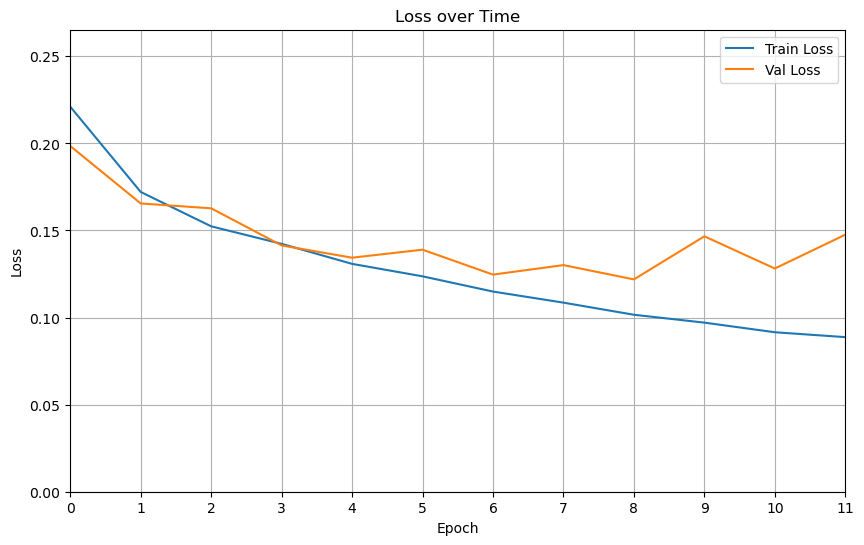

In [2361]:
# Plotting
epochs = range(len(list_of_train_loss))
fig, graph = plt.subplots(figsize=(10, 6))

# Plot average losses per epoch
graph.plot(list(epochs), list_of_train_loss, label='Train Loss', color='tab:blue')
graph.plot(list(epochs), list_of_val_loss, label='Val Loss', color='tab:orange')

# Axis limits and labels
graph.set_ylim(0, max(list_of_val_loss + list_of_train_loss) * 1.2)
graph.set_xlim(min(epochs), max(epochs))
graph.set_xticks(epochs) 
graph.legend()
plt.title("Loss over Time")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


- Jeg vet ikke helt hva som skjer med validation loss. Har prøvd å endre loss rate, endre på dataen, osv. Jeg antar at det er fordi validerings dataen er for spars og at den ikke får generalisere, men idk. 
- Treningen ser bra ut da
- Har seminarleder noen tips :)

In [2362]:
# Save the model
neural_network.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

## Evaluation

In [2363]:
# set model to eval mode
neural_network.eval()

FrogClassifier(
  (conv_layer1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer2): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fully_connected1): Linear(in_features=600, out_features=120, bias=True)
  (bn3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1_fc): Dropout(p=0.3, inplace=False)
  (fully_connected2): Linear(in_features=120, out_features=84, bias=True)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2_fc): Dropout(p=0.3, inplace=False)
  (fully_connected3): Linear(in_features=84, out_features=2, bias=True)
)

This code cell evaluates the trained model on the validation dataset using two key metrics: accuracy and recall, specifically for detecting frogs.  

Accuracy:   
    -The percentage of total predictions that were correct. 
    -Gives a general idea of how well the model performs overall.   

Recall:
    -Measures how well the model identifies actual frogs.   
    -Important when missing a positive case (frog) is more costly than a false alarm.


These metrics help us better understand how the model performs, especially in imbalanced or binary classification settings. High accuracy doesn't always mean good performance on the class of interest. That's why recall is crucial here.

In [2364]:
# Initialize metrics
correct = 0
total = 0
val_loss = 0.0

true_positive = 0
false_negative = 0

all_preds = []
all_labels = []

# Run evaluation
with torch.no_grad():
    for val_inputs, val_labels in valloader:
        outputs = neural_network(val_inputs)
        loss = loss_function(outputs, val_labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

        # For recall calculation (assuming frog = 1)
        true_positive += ((predicted == 1) & (val_labels == 1)).sum().item()
        false_negative += ((predicted == 0) & (val_labels == 1)).sum().item()

        # Store predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(val_labels.cpu().numpy())

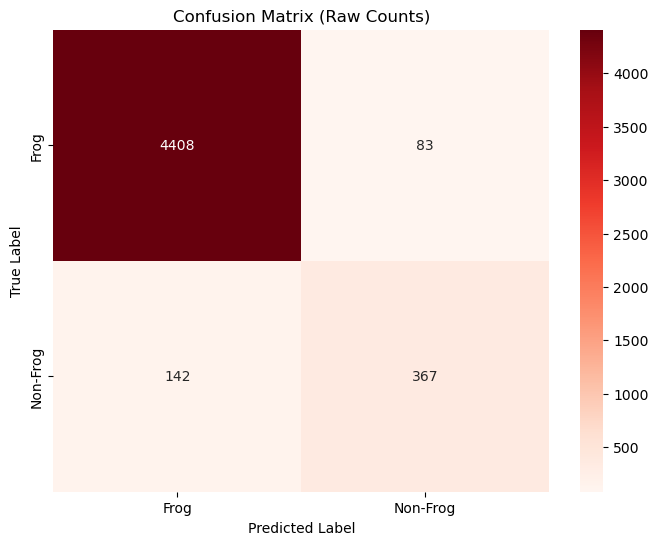


Classification Report:
              precision    recall  f1-score   support

        Frog       0.97      0.98      0.98      4491
    Non-Frog       0.82      0.72      0.77       509

    accuracy                           0.95      5000
   macro avg       0.89      0.85      0.87      5000
weighted avg       0.95      0.95      0.95      5000



In [2365]:
# Confusion Matrix with raw counts
labels = ["Frog", "Non-Frog"]
cm = confusion_matrix(all_labels, all_preds)

# Create DataFrame with raw counts
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

# Plot heatmap with counts
plt.figure(figsize=(8, 6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap="Reds")
plt.title("Confusion Matrix (Raw Counts)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Frog", "Non-Frog"]))


## Prediction on New image

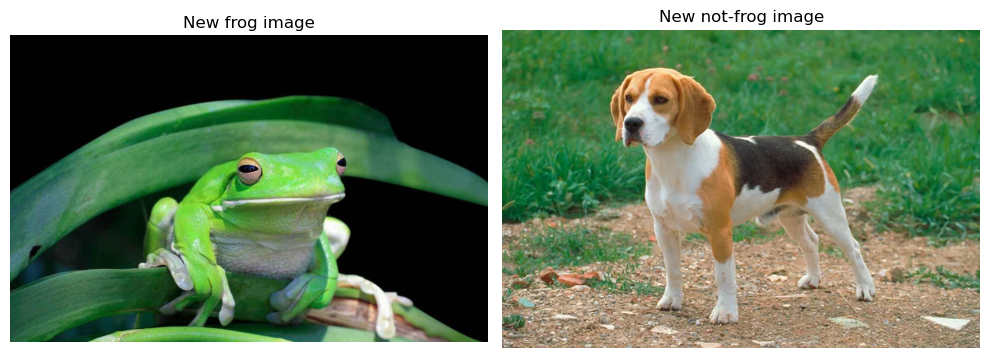

In [2366]:
# Present new image
frog_image = Image.open("/Users/stefannaess/Documents/GitHub/INFO284_SemesterOppgave_2025V/Oppgave2/new_frog_picture.jpg")
not_frog_image = Image.open("/Users/stefannaess/Documents/GitHub/INFO284_SemesterOppgave_2025V/Oppgave2/new_dog_picture.jpg")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(frog_image)
axes[0].set_title("New frog image")
axes[0].axis("off")


axes[1].imshow(not_frog_image)
axes[1].set_title("New not-frog image")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [2367]:
# Transforms
# Transform for changing the image into a 32x32 and normalizing
new_transform = v2.Compose([
    v2.Resize((32, 32)),            
    v2.ToTensor(),                 
    v2.Normalize((0.5, 0.5, 0.5),     
                         (0.5, 0.5, 0.5))
])

# Unnormalize for display
unnormalize = v2.Normalize(
    mean=[-1.0, -1.0, -1.0],
    std=[2.0, 2.0, 2.0]
)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [2368]:
# Present image to be processed

# Apply transform
transformed_frog_image = new_transform(frog_image)
transformed_not_frog_image = new_transform(not_frog_image)


transformed_frog_image = unnormalize(transformed_frog_image)
transformed_not_frog_image = unnormalize(transformed_not_frog_image)

# Convert to (H, W, C) and clip for valid pixel range
display_image_forg = transformed_frog_image.permute(1, 2, 0).numpy()
display_image_not_forg = transformed_not_frog_image.permute(1, 2, 0).numpy()

# Clip intervals outside of normalisation range
display_image_forg = np.clip(display_image_forg, 0, 1)
display_image_not_forg = np.clip(display_image_not_forg, 0, 1)

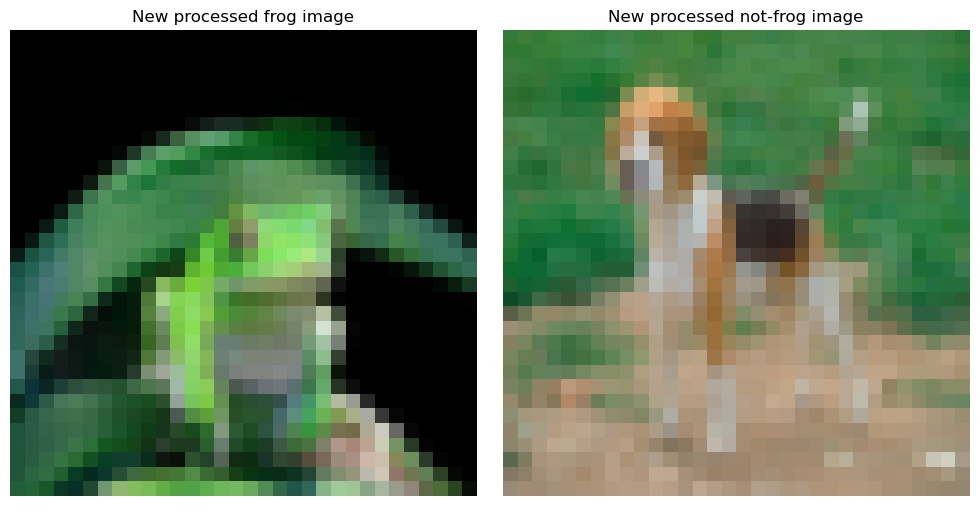

In [2369]:
# Display preprocessed images

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(display_image_forg)
axes[0].set_title("New processed frog image")
axes[0].axis("off")


axes[1].imshow(display_image_not_forg)
axes[1].set_title("New processed not-frog image")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [2370]:
# Load in model
model = FrogClassifier()
model.load_state_dict(torch.load("./cifar_net.pth"))
model.eval()

FrogClassifier(
  (conv_layer1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer2): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fully_connected1): Linear(in_features=600, out_features=120, bias=True)
  (bn3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1_fc): Dropout(p=0.3, inplace=False)
  (fully_connected2): Linear(in_features=120, out_features=84, bias=True)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2_fc): Dropout(p=0.3, inplace=False)
  (fully_connected3): Linear(in_features=84, out_features=2, bias=True)
)

In [2371]:
images = [frog_image, not_frog_image]
# Predicted labels
labels = []

# Make prediction
for img in images:
    # Preprocess image
    processed_img = new_transform(img).unsqueeze(0)
    
    with torch.no_grad():
        
        output = model(processed_img)

        # Prediction
        prediction = torch.argmax(output, dim=1).item()

        # Confidence
        probability = torch.softmax(output, dim=1)
        confidence = probability[0][prediction].item()

        label = f"{'Frog' if prediction == 1 else 'Not Frog'} ({confidence:.2%})"
        labels.append(label)


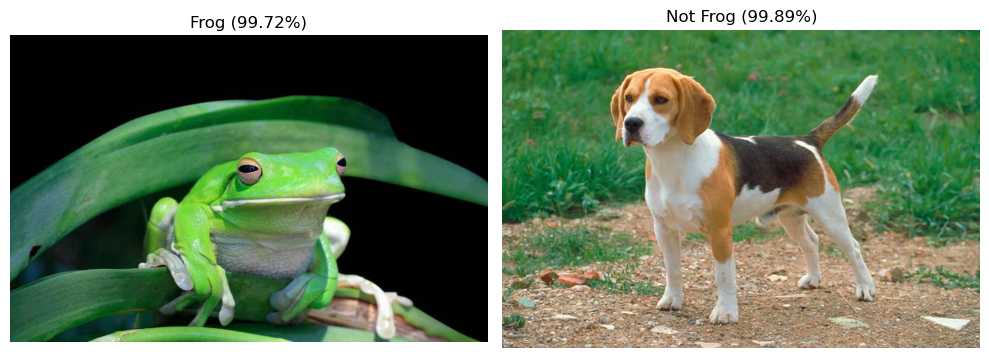

In [2372]:
# Create plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display images
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(labels[i], fontsize=12)
    ax.axis("off")

plt.tight_layout()
plt.show()

Our model achieves approximately 98.91 % accuracy on the test set. While this is a solid result, we can potentially improve further using deeper architectures, better regularization, or improved optimizers.

CNNs works well for image classification. But you need to be careful preprocessing and normalization are crucial. The performance can vary significantly across different classes, often due to visual similarities.